# Generating Water observations from space (WOfS)

## NOTE: modified for PNG on EASI ASIA, original notebook [**here**](https://github.com/csiro-easi/eocsi-hackathon-2022/blob/fa5bbf8b8170bac72b3d5965dcdaf453ef8672c5/case-studies/water-observations-from-space.ipynb)

The [DEA water observation product](https://www.dea.ga.gov.au/products/dea-water-observation) maps the presense of surface water from Landsat imagery. An analysis through time can map the frequency a pixel is inundated by water, which can be used to infer the temporal and spatial statistics of flood/drought events. This notebook demonstrates how to run the DEA water observation algorithm for a given area of interest

- [DEA product and algorithm details](https://cmi.ga.gov.au/data-products/dea/613/dea-water-observations-landsat)
- [Reference code](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/virtualproduct.py)

This notebook requires the "WOfS_Environment", which needs to be installed as in the first cell of this notebook (to be run on commandline). Once done, set the environment in the top-right corner. 


**Notes 1/3/23**
- scaling and offset factor applied to col2 of landsat within the function `transform = WOfSClassifier(c2_scaling=True, dsm_path=DEM_PATH)`  
- cannot get dask cluster working, error messages occur with using `.compute()` suggesting datasets cannot be found

#### Install the WOfS environment using the following on command line


In [1]:
'''
python3 -m venv ~/venvs/WOfS_Environment
source ~/venvs/WOfS_Environment/bin/activate
pip install --upgrade pip
deactivate
realpath /env/lib/python3.10/site-packages > ~/venvs/WOfS_Environment/lib/python3.10/site-packages/base_venv.pth
source ~/venvs/WOfS_Environment/bin/activate
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs
python -m ipykernel install --user --name=WOfS_Environment
'''

'\npython3 -m venv ~/venvs/WOfS_Environment\nsource ~/venvs/WOfS_Environment/bin/activate\npip install --upgrade pip\ndeactivate\nrealpath /env/lib/python3.10/site-packages > ~/venvs/WOfS_Environment/lib/python3.10/site-packages/base_venv.pth\nsource ~/venvs/WOfS_Environment/bin/activate\npip install ephem\npip install --index-url https://packages.dea.ga.gov.au/ wofs\npython -m ipykernel install --user --name=WOfS_Environment\n'

#### Load packages

In [2]:
%matplotlib inline
import os, sys
from pathlib import Path

import numpy as np
import xarray as xr
import rioxarray

import warnings
warnings.filterwarnings('ignore')

import datacube
from datacube.utils import masking
from datacube.utils.cog import write_cog
dc = datacube.Datacube(app='Generating_WOfS')

from dea_tools.plotting import rgb, display_map
from dea_tools.dask import create_local_dask_cluster

# WOfS classifier
from wofs.virtualproduct import WOfSClassifier
from odc.algo import safe_div, apply_numexpr, keep_good_only

#### AWS Access

In [3]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True);

#### display AOI

In [4]:
latitude = (-7.3, -7.4)
longitude = (144.4, 144.5)
display_map(longitude, latitude)

#### Load landsat data and DEM (Copernicus 30m Digital Elevation Model (GLO-30))

In [5]:
# set time range
time = ('2020-01-01', '2020-12-31')

# load data
ds = dc.load(
    product = 'landsat8_c2l2_sr', 
    latitude = latitude,
    longitude = longitude,
    time=time,
    measurements=['blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'qa_pixel'],
    output_crs="EPSG:32755",  # Target CRS - https://epsg.io/?q=Papua%20New%20Guinea%20kind%3APROJCRS
    resolution=(30, -30),     # Target resolution
    group_by='solar_day',     # Group by time method
    dask_chunks={'time': 1, 'x': 100, 'y': 100}
)

# rename bands, needed for rgb function and for xr_geomedian
ds = ds.rename({
    "blue": "nbart_blue",
    "green": "nbart_green",
    "red": "nbart_red",
    "nir08": "nbart_nir",
    "swir16": "nbart_swir_1",
    "swir22": "nbart_swir_2",
    "qa_pixel": "fmask",
})

ds

<xarray.Dataset>
Dimensions:       (time: 20, y: 372, x: 371)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-09T00:32:21.351495 ... 2020-1...
  * y             (y) float64 9.181e+06 9.181e+06 ... 9.192e+06 9.192e+06
  * x             (x) float64 2.24e+05 2.24e+05 2.24e+05 ... 2.13e+05 2.129e+05
    spatial_ref   int32 32755
Data variables:
    nbart_blue    (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nbart_green   (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nbart_red     (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nbart_nir     (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nbart_swir_1  (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nbart_swir_2  (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    fmask         (time, y, x) uint16 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

In [6]:
# load DEM
dem = dc.load(
    product="copernicus_dem_30", 
    latitude=latitude,
    longitude=longitude,
    output_crs="epsg:4326", 
    resolution=(-1/3600, 1/3600),
)
elevation = dem.elevation

In [7]:
# Where to save the DEM (fetched in WOfS function)?
DEM_PATH = "/home/jovyan/dems/PNG_test.tif"

dem_path = Path(DEM_PATH)
dem_path.parent.mkdir(parents=True, exist_ok=True)
elevation.rio.to_raster(dem_path)

#### Classify WOfS
Run the water observations classifier.

In [8]:
transform = WOfSClassifier(c2_scaling=True, dsm_path=DEM_PATH)

# Compute the WOFS layer
wofl = transform.compute(ds)
wofl

<xarray.Dataset>
Dimensions:      (y: 372, x: 371, time: 20)
Coordinates:
  * y            (y) float64 9.181e+06 9.181e+06 ... 9.192e+06 9.192e+06
  * x            (x) float64 2.24e+05 2.24e+05 2.24e+05 ... 2.13e+05 2.129e+05
  * time         (time) datetime64[ns] 2020-01-09T00:32:21.351495 ... 2020-12...
    spatial_ref  int32 32755
Data variables:
    water        (time, y, x) uint8 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    crs:      EPSG:32755

#### Water observations summaries
Water observations summaries, based on [odc-stats/plugins/wofs.py](https://github.com/opendatacube/odc-stats/blob/develop/odc/stats/plugins/wofs.py), consist of:
- `count_clear`: a count of every time a pixel was observed (not obscured by terrain or clouds)
- `count_wet`: a count of every time a pixel was observed and wet
- `frequency`: what fraction of time (wet/clear) was the pixel wet

In [9]:
# Rename dimensions as required
wofl = wofl.rename({"x": "longitude", "y": "latitude"})

In [10]:
wofl["bad"] = (wofl.water & 0b0111_1110) > 0
wofl["some"] = apply_numexpr("((water<<30)>>30)==0", wofl, name="some")
wofl["dry"] = wofl.water == 0
wofl["wet"] = wofl.water == 128
wofl = wofl.drop_vars("water")
for dv in wofl.data_vars.values():
    dv.attrs.pop("nodata", None)

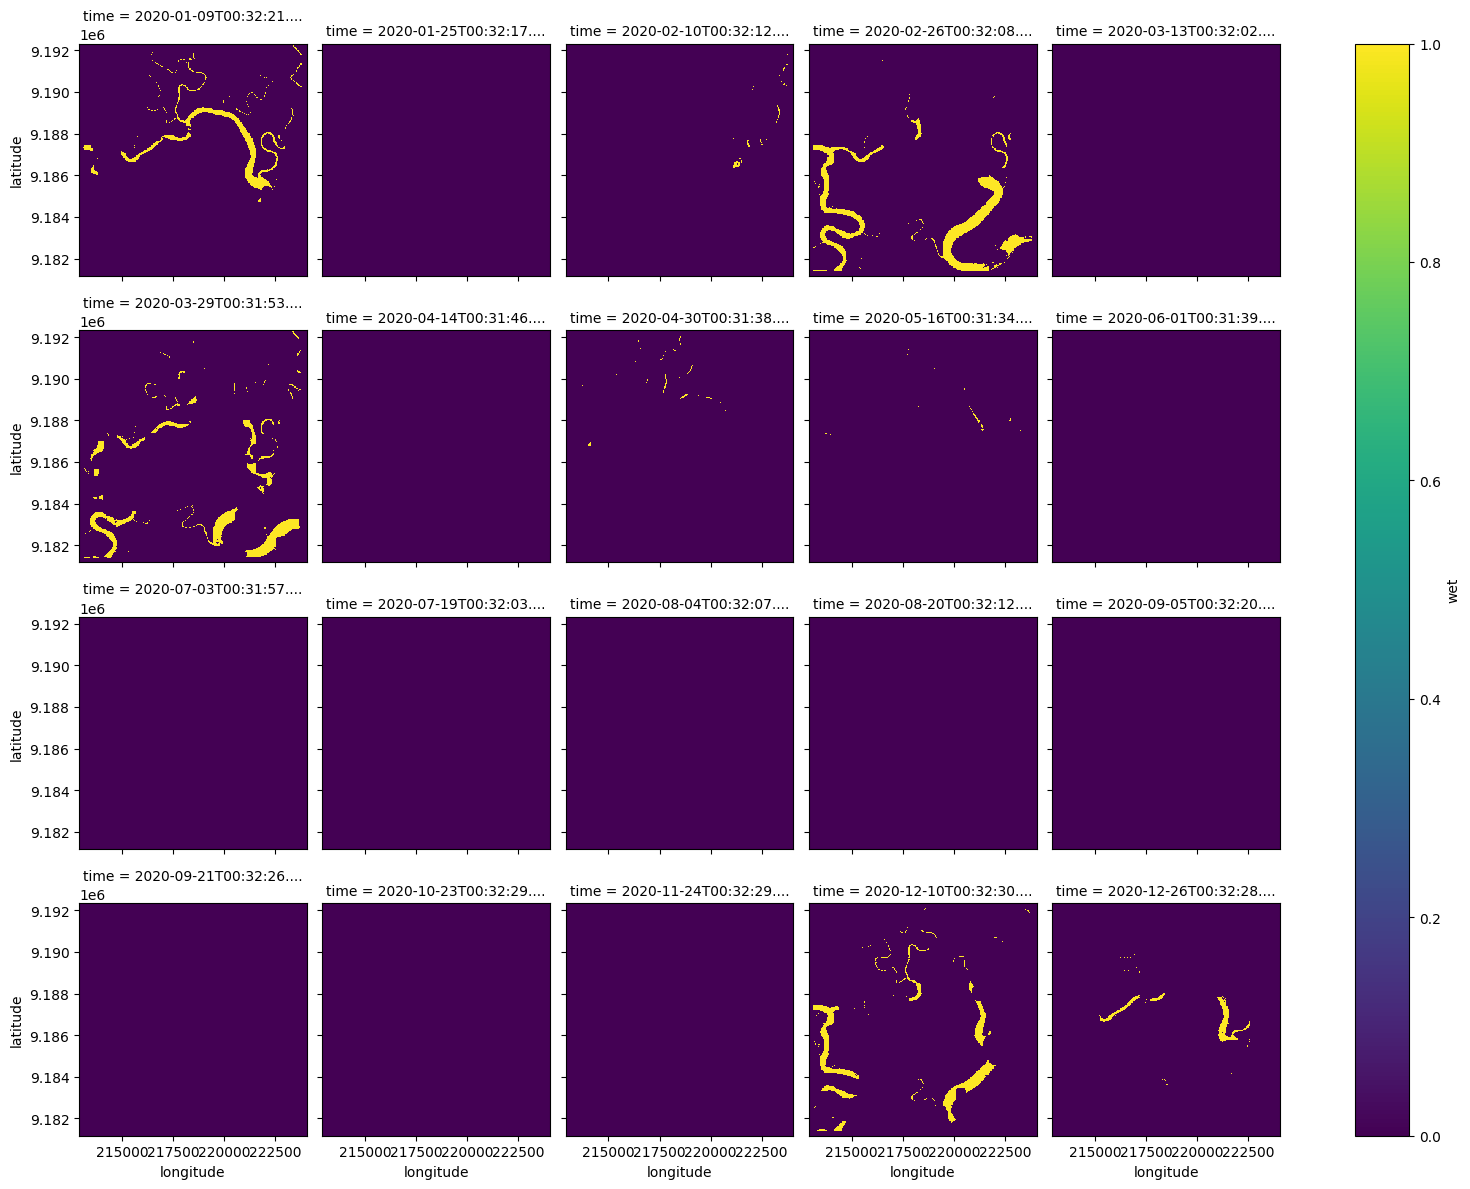

In [11]:
# plot all wet observations (takes a couple minutes)

# Ignore warnings triggered by time slices without data at all
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide") 
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide") 

wofl.wet.plot(col="time", col_wrap=5);

In [12]:
# Helper frunction from https://github.com/opendatacube/odc-stats/blob/develop/odc/stats/plugins/wofs.py

def reduce(xx: xr.Dataset) -> xr.Dataset:
    nodata = -999
    count_some = xx.some.sum(axis=0, dtype="int16")
    count_wet = xx.wet.sum(axis=0, dtype="int16")
    count_dry = xx.dry.sum(axis=0, dtype="int16")
    count_clear = count_wet + count_dry
    frequency = safe_div(count_wet, count_clear, dtype="float32")

    count_wet.attrs["nodata"] = nodata
    count_clear.attrs["nodata"] = nodata

    is_ok = count_some > 0
    count_wet = keep_good_only(count_wet, is_ok)
    count_clear = keep_good_only(count_clear, is_ok)

    return xr.Dataset(
        dict(
            count_wet=count_wet,
            count_clear=count_clear,
            frequency=frequency,
        )
    )

summary = reduce(wofl)

In [13]:
%%time
wofs_freq = summary.frequency.compute()

CPU times: user 3min 32s, sys: 1min 43s, total: 5min 16s
Wall time: 6min 23s


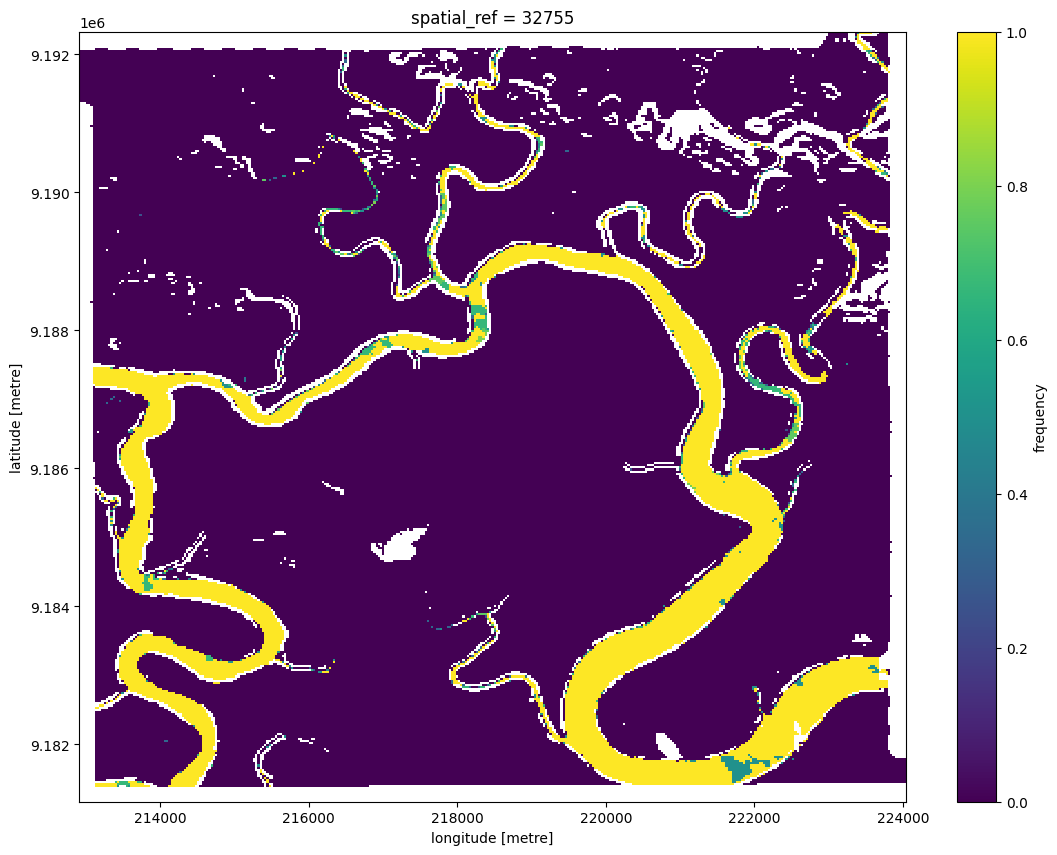

In [14]:
wofs_freq.plot(size=10)

In [15]:
# add crs and to_array for cog output
wofs_freq.attrs['crs'] = 'EPSG:32755'
# geomedian_export = geomedian.to_array()

# output as cog
write_cog(wofs_freq, '../data/wofs_test.tif', overwrite=True)

PosixPath('../data/wofs_test.tif')